In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


In [3]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

# Throughput

In [4]:
THRP_PREFIX = "main/cockroach"

thrp_index_sdf = get_index(THRP_PREFIX).cache()
thrp_index_df = thrp_index_sdf\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
    .toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
    })

thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot1000000mh100,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,100
1,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot1000000mh50,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,50
2,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot100000mh100,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,100
3,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot1000000mh0,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,0
4,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot100000mh50,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,50
5,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot10000mh100,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,100
6,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot100000mh0,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,0
7,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot10000mh50,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,50
8,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot1000mh100,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000,100
9,file:///home/ctring/data/slog/main/cockroach/ddr_ts-hot10000mh0,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,0


## SLOG throughput

In [5]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_sdf),
    ignore_cache=IGNORE_CACHE,
)

## CockroachDB throughput

In [6]:
crdb_schema = StructType([
    StructField("wl:mh", T.IntegerType(), False),
    StructField("wl:hot", T.IntegerType(), False),
    StructField("region", T.StringType(), False),
    StructField("type", T.StringType(), False),
    StructField("count", T.IntegerType(), False),
    StructField("throughput", T.DoubleType(), False),
    StructField("avg", T.DoubleType(), False),
    StructField("p50", T.DoubleType(), False),
    StructField("p95", T.DoubleType(), False),
    StructField("p99", T.DoubleType(), False),
    StructField("pMax", T.DoubleType(), False),
])

crdb_sdf = spark.read.csv("crdb.csv", header=True, schema=crdb_schema)

crdb_df = crdb_sdf\
    .groupBy("wl:mh", "wl:hot")\
    .agg(F.sum("throughput").alias("crdb"))\
    .toPandas()

crdb_df.set_index(["wl:mh", "wl:hot"], inplace=True)
crdb_df.sort_index(inplace=True, ascending=[True, False])

crdb_df.columns = crdb_df.columns.set_names("config_name")
crdb_df

config_name       crdb
wl:mh wl:hot          
0     1000000  14550.2
      100000   14443.1
      10000    13495.2
      1000      1956.3
      100        585.5
      10          90.2
50    1000000  11802.5
      100000   11546.5
      10000     9306.0
      1000       248.3
      100        185.8
      10          39.9
100   1000000  10078.0
      100000    9829.7
      10000     5722.0
      1000       240.5
      100        100.5
      10          24.1

## Plot

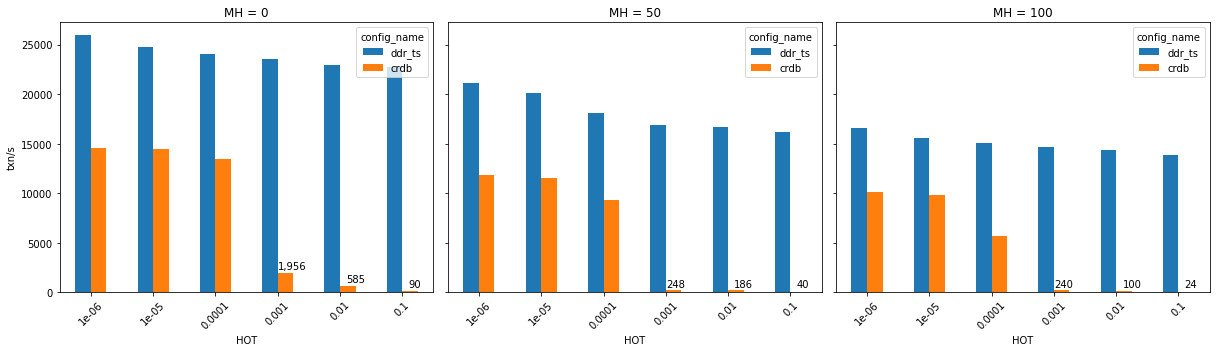

In [7]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = ["wl:mh", "wl:hot"]

pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index(ascending=[True, False])
combined = pivoted.join(crdb_df)

_, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

combined.loc[(0, slice(None)), :].plot.bar(ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="txn/s", rot=45)
combined.loc[(50, slice(None)), :].plot.bar(ax=axes[1], title="MH = 50", xlabel="HOT", rot=45)
combined.loc[(100, slice(None)), :].plot.bar(ax=axes[2], title="MH = 100", xlabel="HOT", rot=45)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

def disp(x):
    return f'{x:,.0f}'

HEIGHT = 500
axes[0].annotate(disp(crdb_df.loc[(0, 1000), 'crdb']), (3, HEIGHT + 1800))
axes[0].annotate(disp(crdb_df.loc[(0, 100), 'crdb']), (4.1, HEIGHT + 500))
axes[0].annotate(disp(crdb_df.loc[(0, 10), 'crdb']), (5.1, HEIGHT))
axes[1].annotate(disp(crdb_df.loc[(50, 1000), 'crdb']), (3, HEIGHT + 0.08))
axes[1].annotate(disp(crdb_df.loc[(50, 100), 'crdb']), (4.1, HEIGHT))
axes[1].annotate(disp(crdb_df.loc[(50, 10), 'crdb']), (5.1, HEIGHT))
axes[2].annotate(disp(crdb_df.loc[(100, 1000), 'crdb']), (3, HEIGHT + 0.08))
axes[2].annotate(disp(crdb_df.loc[(100, 100), 'crdb']), (4.1, HEIGHT))
axes[2].annotate(disp(crdb_df.loc[(100, 10), 'crdb']), (5.1, HEIGHT))

plt.tight_layout()

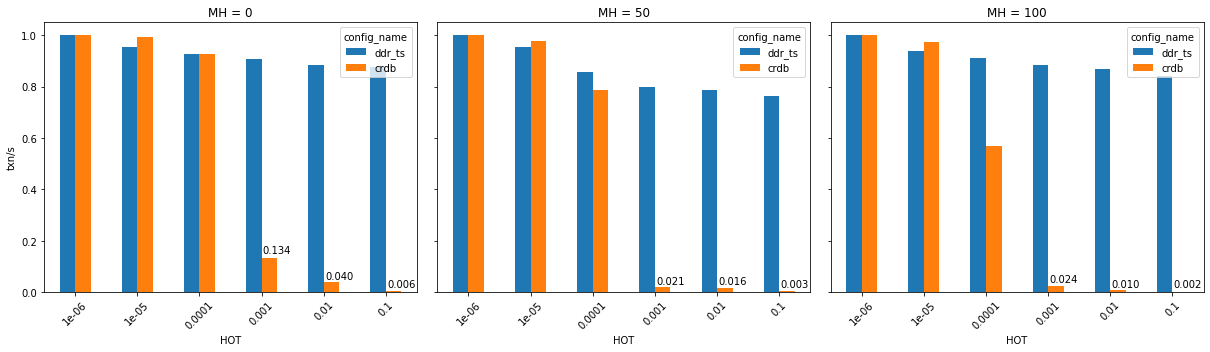

In [9]:
def normalize_per_mh(df):
    mh_pcts = df.index.get_level_values(0).unique()
    for mh_pct in mh_pcts:
        g = df.loc[(mh_pct, slice(None)), :]
        df.loc[(mh_pct, slice(None)), :] /= g.loc[(mh_pct, 1000000), :]
    return df    

crdb_norm_df = normalize_per_mh(crdb_df.copy())
slog_norm_df = normalize_per_mh(pivoted.copy())
combined_norm = slog_norm_df.join(crdb_norm_df)

combined_norm

_, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

combined_norm.loc[(0, slice(None)), :].plot.bar(ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="txn/s", rot=45)
combined_norm.loc[(50, slice(None)), :].plot.bar(ax=axes[1], title="MH = 50", xlabel="HOT", rot=45)
combined_norm.loc[(100, slice(None)), :].plot.bar(ax=axes[2], title="MH = 100", xlabel="HOT", rot=45)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

HEIGHT = 0.02

def disp(x):
    return f'{x:,.3f}'

axes[0].annotate(disp(crdb_norm_df.loc[(0, 1000), 'crdb']), (3.02, HEIGHT + 0.13))
axes[0].annotate(disp(crdb_norm_df.loc[(0, 100), 'crdb']), (4.02, HEIGHT + 0.03))
axes[0].annotate(disp(crdb_norm_df.loc[(0, 10), 'crdb']), (5.02, HEIGHT))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 1000), 'crdb']), (3.02, HEIGHT + 0.01))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 100), 'crdb']), (4.02, HEIGHT + 0.01))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 10), 'crdb']), (5.02, HEIGHT))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 1000), 'crdb']), (3.02, HEIGHT + 0.02))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 100), 'crdb']), (4.02, HEIGHT))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 10), 'crdb']), (5.02, HEIGHT))

plt.tight_layout()
plt.savefig('output/cockroach-rel-throughput.pdf')

# Deadlock

In [10]:
crdb_cnt_df = crdb_sdf\
    .withColumn("type", F.regexp_replace("type", "too-old", "other"))\
    .groupBy("wl:mh", "wl:hot", "type")\
    .agg(F.sum("count").alias("count"))\
    .withColumn("pct", 
                100*F.col("count") / F.sum("count").over(
                    Window.partitionBy("wl:mh", "wl:hot")
                )
               )\
    .toPandas()

crdb_cnt_df

,wl:mh,wl:hot,type,count,pct
0,100,10000,other,218,0.042329
1,100,10000,deadlock,328,0.063688
2,100,10000,write,514462,99.893982
3,50,10,other,45,1.253482
4,50,10,write,112,3.119777
...,...,...,...,...,...
46,100,100,deadlock,6278,69.500720
47,100,100,write,2521,27.908779
48,50,1000,write,21471,96.058518
49,50,1000,other,123,0.550286


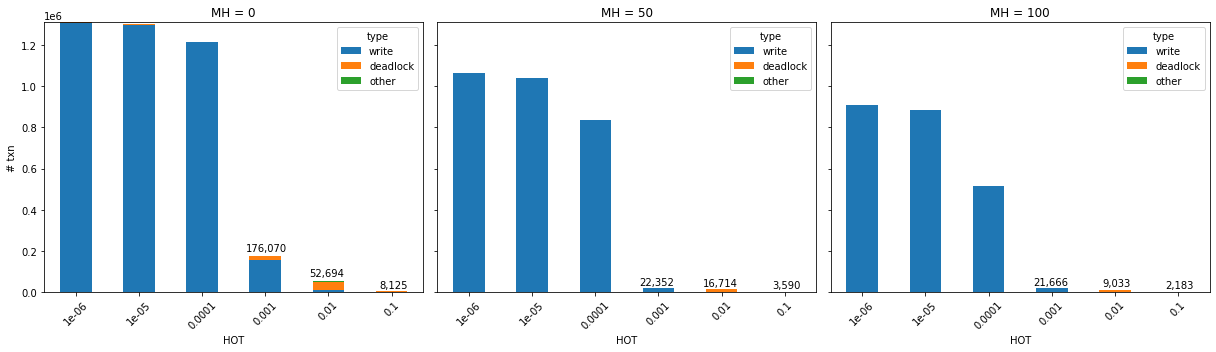

In [149]:
crdb_cnt_pivot_df = crdb_cnt_df.pivot(index=["wl:mh", "wl:hot"], columns="type", values="count")
crdb_cnt_pivot_df.sort_index(inplace=True, ascending=[True, False])
crdb_cnt_pivot_df["sum"] = crdb_cnt_pivot_df["write"] + crdb_cnt_pivot_df['deadlock'] + crdb_cnt_pivot_df['other']

_, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

bars = ['write', 'deadlock', 'other']

crdb_cnt_pivot_df.loc[(0, slice(None)), :].plot.bar(y=bars, ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="# txn", rot=45, stacked=True)
crdb_cnt_pivot_df.loc[(50, slice(None)), :].plot.bar(y=bars, ax=axes[1], title="MH = 50", xlabel="HOT", rot=45, stacked=True)
crdb_cnt_pivot_df.loc[(100, slice(None)), :].plot.bar(y=bars, ax=axes[2], title="MH = 100", xlabel="HOT", rot=45, stacked=True)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

def disp(x):
    return f'{x:,.0f}'

HEIGHT = 20000

axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 1000), 'sum']), (2.7, HEIGHT + 180000))
axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 100), 'sum']), (3.7, HEIGHT + 60000))
axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 10), 'sum']), (4.8, HEIGHT))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 1000), 'sum']), (2.7, HEIGHT + 15000))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 100), 'sum']), (3.7, HEIGHT + 10000))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 10), 'sum']), (4.8, HEIGHT))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 1000), 'sum']), (2.7, HEIGHT + 15000))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 100), 'sum']), (3.8, HEIGHT + 10000))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 10), 'sum']), (4.8, HEIGHT))
    
plt.tight_layout()

In [111]:
crdb_cnt_pivot_df

type           deadlock   other      write
wl:mh wl:hot                              
0     1000000    1032.0     2.0  1308567.0
      100000     1986.0    20.0  1297929.0
      10000       837.0   827.0  1212969.0
      1000      16423.0  2353.0   157294.0
      100       42441.0  1206.0     9047.0
      10         7912.0    67.0      146.0
50    1000000     101.0     NaN  1062189.0
      100000      959.0     2.0  1038263.0
      10000       798.0    40.0   836718.0
      1000        758.0   123.0    21471.0
      100       13530.0   411.0     2773.0
      10         3433.0    45.0      112.0
100   1000000      80.0     NaN   907004.0
      100000      116.0     NaN   884621.0
      10000       328.0   218.0   514462.0
      1000        191.0    46.0    21429.0
      100        6278.0   234.0     2521.0
      10         1975.0    22.0      186.0

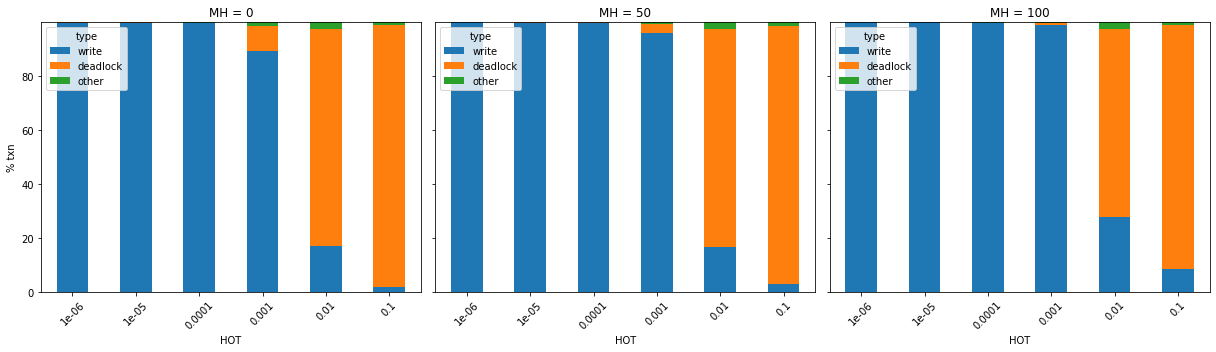

In [11]:
crdb_pct_pivot_df = crdb_cnt_df.pivot(index=["wl:mh", "wl:hot"], columns="type", values="pct")
crdb_pct_pivot_df.sort_index(inplace=True, ascending=[True, False])

_, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

bars = ['write', 'deadlock', 'other']

crdb_pct_pivot_df.loc[(0, slice(None)), :].plot.bar(y=bars, ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="% txn", rot=45, stacked=True)
crdb_pct_pivot_df.loc[(50, slice(None)), :].plot.bar(y=bars, ax=axes[1], title="MH = 50", xlabel="HOT", rot=45, stacked=True)
crdb_pct_pivot_df.loc[(100, slice(None)), :].plot.bar(y=bars, ax=axes[2], title="MH = 100", xlabel="HOT", rot=45, stacked=True)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

plt.tight_layout()
plt.savefig('output/cockroach-pct-abort.pdf')

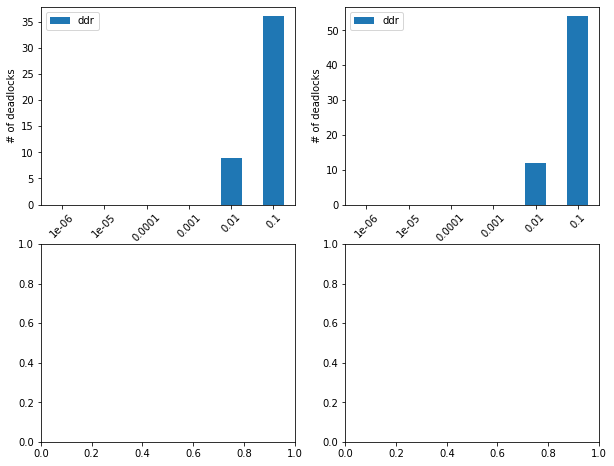

In [188]:
mh_pcts = [50, 100]
hots = [1000000, 100000, 10000, 1000, 100, 10]

data = {}
for mh in mh_pcts:
    data[mh] = []
    for hot in hots:
        mask = (thrp_index_df["wl:mh"] == mh) & (thrp_index_df["wl:hot"] == hot)
        prefix = thrp_index_df.loc[mask, "prefix"].iloc[0]
        deadlocks_df = deadlocks_csv(spark, prefix).where(col("replica") == 0).toPandas()
        data[mh].append(deadlocks_df["vertices"])
    
# Box plots
_, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, mh in enumerate(mh_pcts):
    cnt = []
    for j, hot in enumerate(hots):
        cnt.append(data[mh][j].count())
    cnt_df = pd.DataFrame(data={'ddr': cnt}, index=1 / np.array(hots))
    cnt_df.plot.bar(ax=axes[0, i], rot=45, ylabel='# of deadlocks', xlabel='HOT')

# Latency

In [23]:
LAT_PREFIX = "main/cockroach-latency"

lat_index_sdf = get_index(LAT_PREFIX).cache()
lat_index_df = lat_index_sdf.toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
    })

lat_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000000mh100,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000000,100
1,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000000mh50,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000000,50
2,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100000mh100,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100000,100
3,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000000mh0,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000000,0
4,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100000mh50,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100000,50
5,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10000mh100,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10000,100
6,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100000mh0,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100000,0
7,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10000mh50,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10000,50
8,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000mh100,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000,100
9,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10000mh0,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10000,0


In [24]:
prefixes = list(map(lambda r : r["prefix"], lat_index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

slog_latency_sdf = latency_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [25]:
IGNORE_CACHE = True

slog_latency_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency.parquet',
    lambda: slog_latency_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)
slog_latency_df

Saved to: main/cockroach-latency/latency.parquet


,prefix,p50,p95,p99,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000mh100,76.848640,157.298688,161.471744,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000,100
1,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000000mh50,15.285248,148.268288,179.643136,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000000,50
2,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100000mh100,77.658624,152.516864,156.740608,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100000,100
3,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100mh100,77.483520,157.654784,161.422592,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100,100
4,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000000mh0,9.227008,10.298880,11.403520,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000000,0
5,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot1000mh50,18.908672,147.747328,160.525824,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,1000,50
6,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot100mh50,28.395264,147.511296,160.313088,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,100,50
7,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10mh50,61.204992,147.576576,160.463104,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10,50
8,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10mh100,86.123008,157.601792,161.591808,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10,100
9,file:///home/ctring/data/slog/main/cockroach-latency/ddr_ts-hot10000mh0,9.202944,10.479360,11.810304,1.0.1029,ddr_ts.conf,30,2000000,16,0,10,cockroach,100,10,10000,0


In [26]:
crdb_schema = StructType([
    StructField("wl:mh", T.IntegerType(), False),
    StructField("wl:hot", T.IntegerType(), False),
    StructField("region", T.StringType(), False),
    StructField("throughput", T.DoubleType(), False),
    StructField("avg", T.DoubleType(), False),
    StructField("p50", T.DoubleType(), False),
    StructField("p95", T.DoubleType(), False),
    StructField("p99", T.DoubleType(), False),
    StructField("pMax", T.DoubleType(), False),
])
crdb_latency_df = spark.read.csv("crdb-latency.csv", header=True, schema=crdb_schema)\
    .groupBy("wl:mh", "wl:hot")\
    .agg(
        F.avg("p50").alias("p50"),
        F.avg("p95").alias("p95"),
        F.avg("p99").alias("p99"),
    )\
    .toPandas()

crdb_latency_df["config_name"] = "crdb"
crdb_latency_df

,wl:mh,wl:hot,p50,p95,p99,config_name
0,100,10000,805.316667,1437.250000,1448.433333,crdb
1,50,10,4982.850000,42054.900000,47602.550000,crdb
2,50,100,648.733333,2304.050000,3892.283333,crdb
3,0,1000000,20.100000,26.933333,29.900000,crdb
4,0,10,788.550000,3735.716667,5905.600000,crdb
5,100,1000000,810.916667,1437.250000,1470.800000,crdb
6,100,1000,805.316667,1448.433333,2046.816667,crdb
7,50,1000000,86.866667,1437.250000,1515.533333,crdb
8,0,100000,20.633333,27.266667,30.083333,crdb
9,0,1000,20.433333,27.283333,39.466667,crdb


In [27]:
def plot_latency(df, yscale='log'):
    _, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True)

    configs = df["config_name"].unique()
    mh_pcts = sorted(df["wl:mh"].unique())
    hots = sorted(df["wl:hot"].unique(), reverse=False)
    
    colors = ['C0', 'C1']

    for i, config in enumerate(configs):
        for r, mh_pct in enumerate(mh_pcts):
            mask = (df["config_name"] == config) & (df["wl:mh"] == mh_pct)
            filtered = df[mask].sort_values("wl:hot", ascending=False)
            label = config.replace('.conf', '')

            filtered.plot(ax=axes[r], x="wl:hot", y="p50", label=f'{label}_50', linestyle='dotted', marker='.', color=colors[i])
            filtered.plot(ax=axes[r], x="wl:hot", y="p95", label=f'{label}_95', linestyle='dashed', marker='.', color=colors[i])
            filtered.plot(ax=axes[r], x="wl:hot", y="p99", label=f'{label}_99', marker='.', color=colors[i])

            axes[r].set_title(f"MH_PCT = {mh_pct}")
            axes[r].set_ylabel("latency (ms)")
            axes[r].set_xlabel("HOT")
            axes[r].grid(axis='y')
            axes[r].set_yscale(yscale)
            axes[r].set_xscale('log')
            if r != 0:
                axes[r].legend([])

    plt.tight_layout()

In [28]:
latency_df = pd.concat([slog_latency_df, crdb_latency_df])
latency_df.loc[:, "wl:hot"] = 1 / latency_df.loc[:, "wl:hot"]

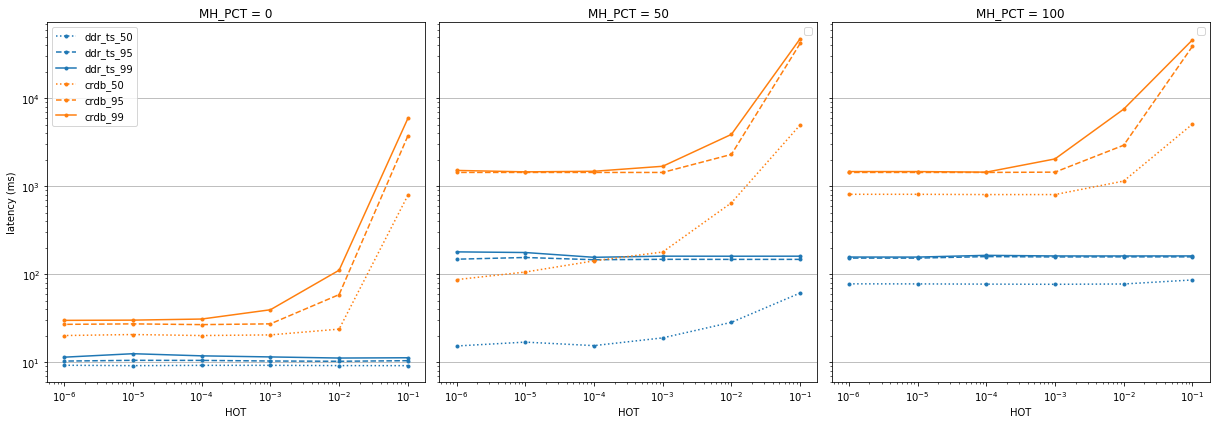

In [29]:
plot_latency(latency_df)